## multi-detuning

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.channels.dmm import DMM
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, CompositeWaveform, RampWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from dwave_networkx.algorithms.independent_set import maximum_weighted_independent_set_qubo
np.set_printoptions(linewidth=np.inf, suppress=True)
from pprint import pprint

In [2]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    # indexes = ["01011", "00111"]  # QUBO solutions
    # color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5)
    plt.xticks(rotation="vertical")
    plt.show()

In [3]:
# qubits = {
#     '0': (0,0),
#     '1': (-4,-7),
#     '2': (4,-7),
#     '3': (8, 6),
#     '4': (-8,6),
#     '5': (0, 14)
# }
# n_qubits = len(qubits)
# weights = np.array([10.0, 1 , 2, 3, 1, 1])
# scale = np.sum(weights)
# weights /= scale
# print(weights)
# reg = Register(qubits)

# detuning_map = reg.define_detuning_map(
#     {str(i): weights[i] for i in range(n_qubits)}  # mapping between trap ids and weights
# )

# reg.draw(
#     blockade_radius=Chadoq2.rydberg_blockade_radius(1.0) ,
#     draw_graph=True,
#     draw_half_radius=True,
# )

In [4]:
# # link_max = 10
# # no_link_min = 13.6

# # omega_min = Chadoq2.interaction_coeff / no_link_min ** 6
# # omega_max = Chadoq2.interaction_coeff / link_max ** 6
# # omega = (omega_min + omega_max)/2

# omega = 2.0
# # print(omega)

# delta_0 = -2
# delta_f = -delta_0
# T = 1000

# # adiabatic_pulse = Pulse(
# #     amplitude=InterpolatedWaveform(T, [1e-9, omega, omega, omega / 4, 1e-9]),
# #     detuning=InterpolatedWaveform(T, [delta_0, 0, delta_f / 3, delta_f, delta_f]),
# #     phase=0,
# # )

# adiabatic_pulse = Pulse(
#     InterpolatedWaveform(T, [1e-9, omega, 1e-9]),
#     InterpolatedWaveform(T, [delta_0, 0, delta_f]),
#     0,
# )

# seq = Sequence(reg, Chadoq2)
# seq.declare_channel("ising", "rydberg_global")
# seq.config_detuning_map(detuning_map, "dmm_0")
# seq.add(adiabatic_pulse, "ising")
# seq.add_dmm_detuning(ConstantWaveform(T, -1), "dmm_0")

# seq.draw(mode="input+output",  # "input" only shows input signals, "input+output"
#         draw_qubit_det=True,
#         draw_qubit_amp=True,
#         draw_detuning_maps=True)

In [5]:
# simul = QutipEmulator.from_sequence(seq)
# results = simul.run()
# final = results.get_final_state()
# count_dict = results.sample_final_state()
# plot_distribution(count_dict)

## mwis

In [6]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [7]:
from julia import UnitDiskMapping as udm, GenericTensorNetworks as gtn

In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from dwave_networkx.algorithms.independent_set import maximum_weighted_independent_set_qubo
np.set_printoptions(linewidth=np.inf, suppress=True)

In [9]:
n = 2
J = np.triu(np.random.randn(n, n) * 0.001, 1)
J += J.T
h = np.random.randn(n) * 0.001
J, h

(array([[0.        , 0.00065304],
        [0.00065304, 0.        ]]),
 array([ 0.00010655, -0.00096035]))

In [10]:
qubo = udm.map_qubo(J, h)
qubo 

<PyCall.jlwrap UnitDiskMapping.QUBOResult{UnitDiskMapping.WeightedNode{Float64}}(UnitDiskMapping.GridGraph{UnitDiskMapping.WeightedNode{Float64}} (radius = 1.5)
⋅ ⋅ ● ⋅ 
● ● ● ⋅ 
⋅ ● ● ● 
⋅ ● ⋅ ⋅ , [1, 5], 6)>

In [11]:
qubo_graph, qubo_weights = udm.graph_and_weights(qubo.grid_graph)

In [12]:
radius = qubo.grid_graph.radius
radius

1.5

In [13]:
nodes = []
weights = []
for node_data in qubo.grid_graph.nodes:
    node, w = eval(str(node_data).split('}')[-1][:-1])
    nodes.append(list(node))
    weights.append(w)

nodes = np.array(nodes)
weights = np.array(weights)
nodes, weights

(array([[2, 1],
        [2, 2],
        [3, 2],
        [4, 2],
        [1, 3],
        [2, 3],
        [3, 3],
        [3, 4]]),
 array([1.00010655, 3.99934696, 4.00065304, 1.00096035, 0.99903965, 4.00065304, 3.99934696, 0.99989345]))

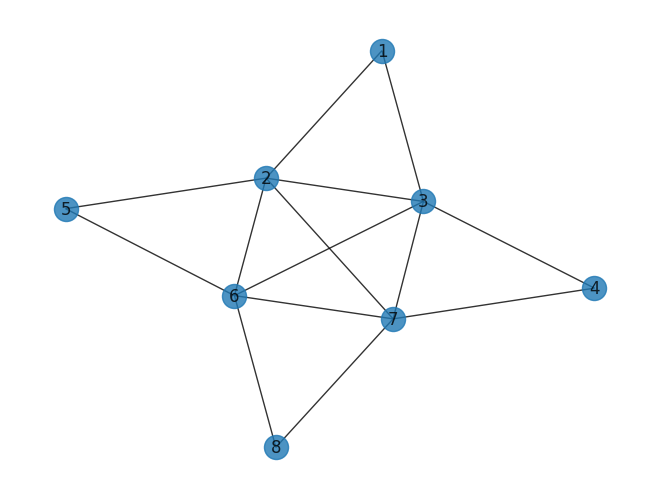

In [14]:
G = nx.Graph()
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        if np.sum(np.abs(nodes[i] - nodes[j])**2) < radius**2:
            G.add_edge(i+1, j+1)
            
nx.set_node_attributes(G, dict(zip(np.arange(0, len(nodes)) + 1, nodes)), 'pos')
nx.set_node_attributes(G, dict(zip(np.arange(0, len(nodes)) + 1, weights)), 'weight')
nx.draw(G, pos=nx.spring_layout(G, seed=42), alpha=0.8, with_labels=True)

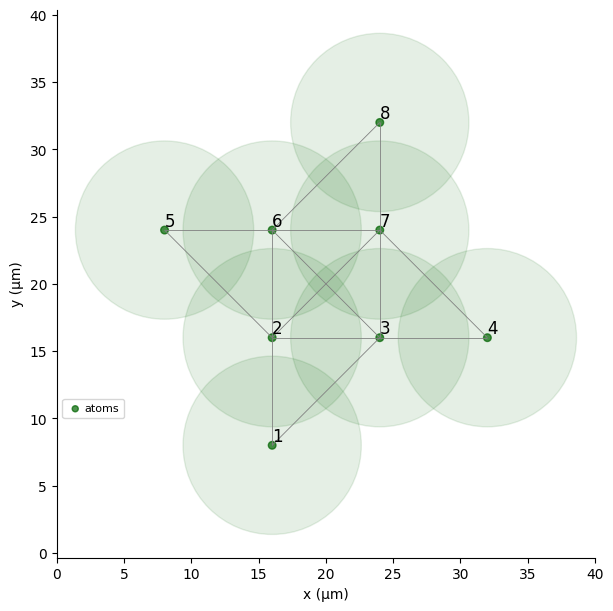

In [15]:
a = 8
qubits = dict(zip(np.arange(0, len(nodes)) + 1, nodes*a))
reg= Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0) ,
    draw_graph=True,
    draw_half_radius=True,
)

In [16]:
n_qubits = len(nodes)
scale = np.max(weights)
print(weights)
weights = scale - weights
# weights /= scale
print(weights)

weights /= np.sum(weights)
print(weights)

detuning_map = reg.define_detuning_map(
    {i+1: weights[i] for i in range(n_qubits)}  # mapping between trap ids and weights
)

[1.00010655 3.99934696 4.00065304 1.00096035 0.99903965 4.00065304 3.99934696 0.99989345]
[3.00054649 0.00130608 0.         2.99969269 3.00161339 0.         0.00130608 3.0007596 ]
[0.24993673 0.00010879 0.         0.24986561 0.2500256  0.         0.00010879 0.24995448]


In [17]:
link_max = np.sqrt(2)*a
no_link_min = 2*a

omega_min = Chadoq2.interaction_coeff / no_link_min ** 6
omega_max = Chadoq2.interaction_coeff / link_max ** 6
omega = (omega_min + omega_max)/2
omega

1.4537998071312899

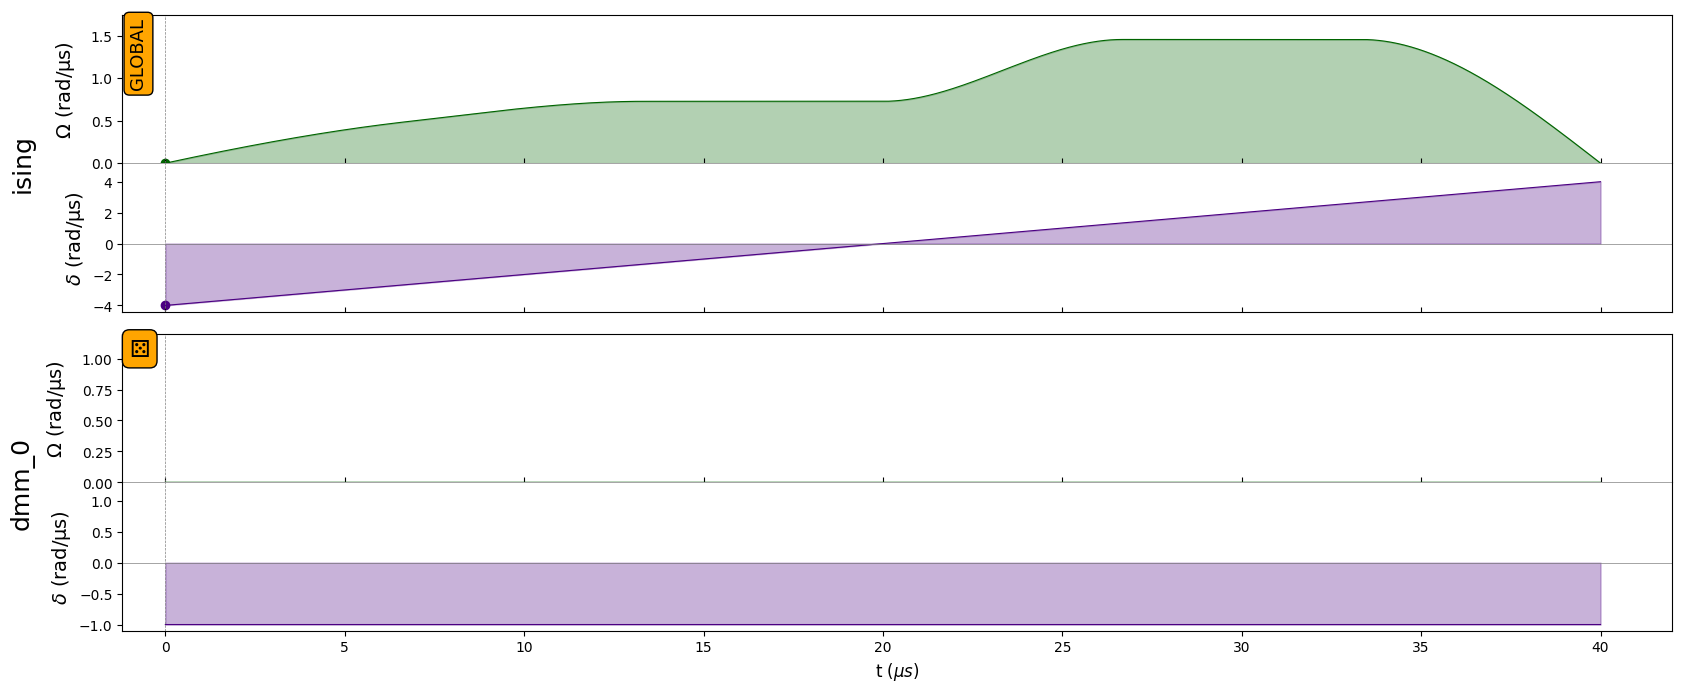

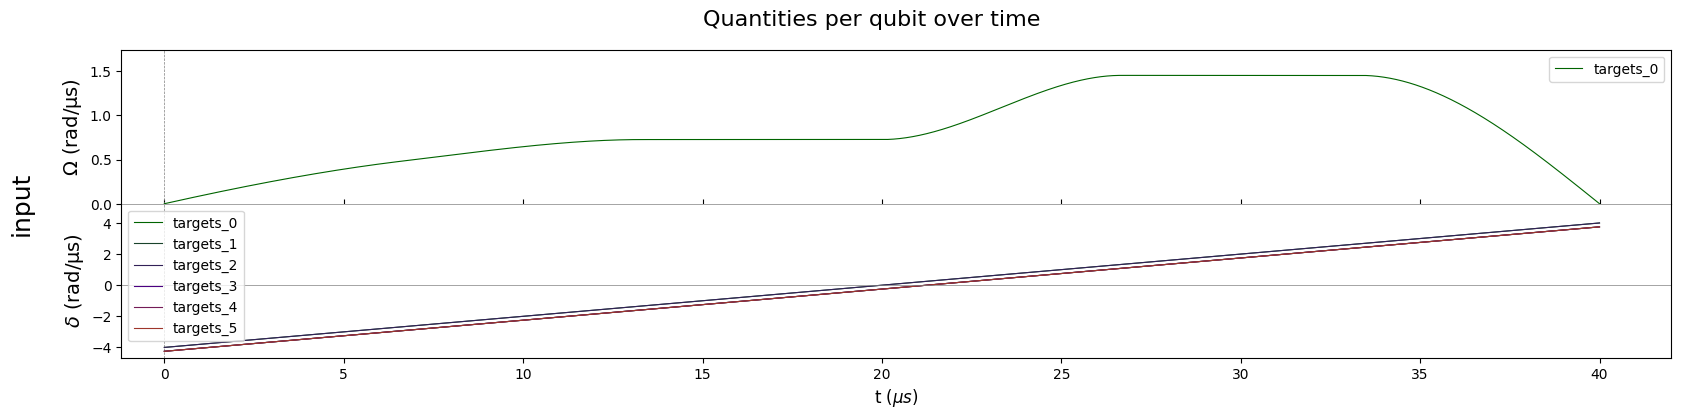

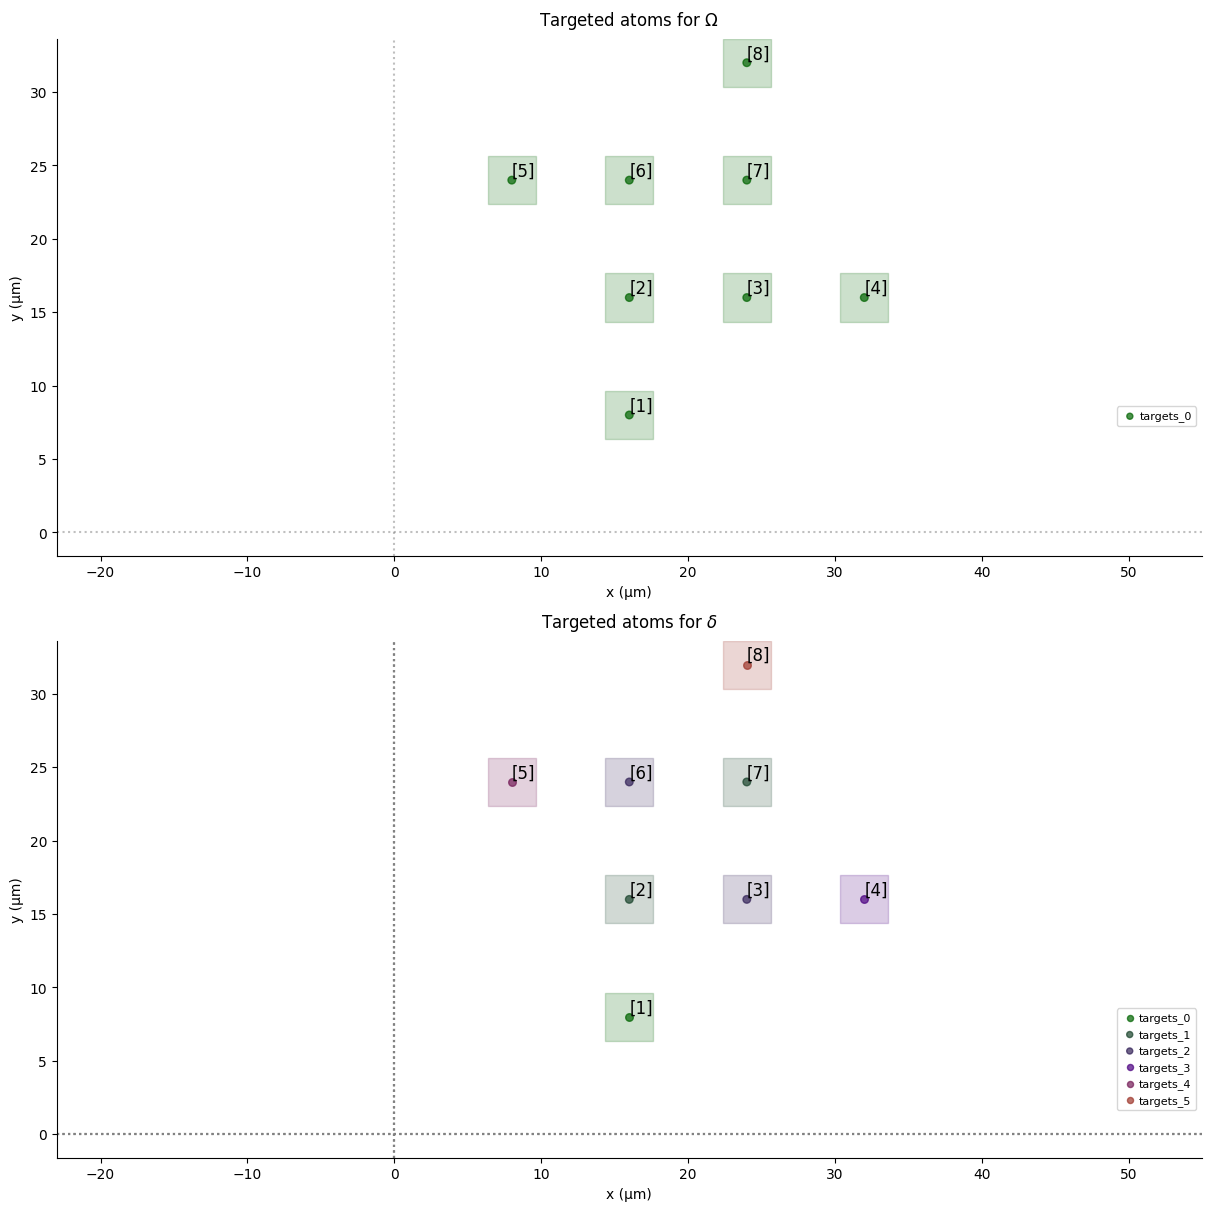

In [18]:
# omega = 15.0

delta_0 = -4.0
delta_f = -delta_0
T = 40000

# adiabatic_pulse = Pulse(
#     amplitude=InterpolatedWaveform(T, [1e-9, omega, omega, omega / 4, 1e-9]),
#     detuning=InterpolatedWaveform(T, [delta_0, 0, delta_f / 3, delta_f, delta_f]),
#     phase=0,
# )

adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, omega/3, omega/2, omega/2, omega, omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)

seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.config_detuning_map(detuning_map, "dmm_0")
seq.add(adiabatic_pulse, "ising")
seq.add_dmm_detuning(ConstantWaveform(T, -1), "dmm_0")

seq.draw(mode="input+output",  # "input" only shows input signals, "input+output"
        draw_qubit_det=True,
        draw_qubit_amp=True,
        # draw_detuning_maps=True,
        )

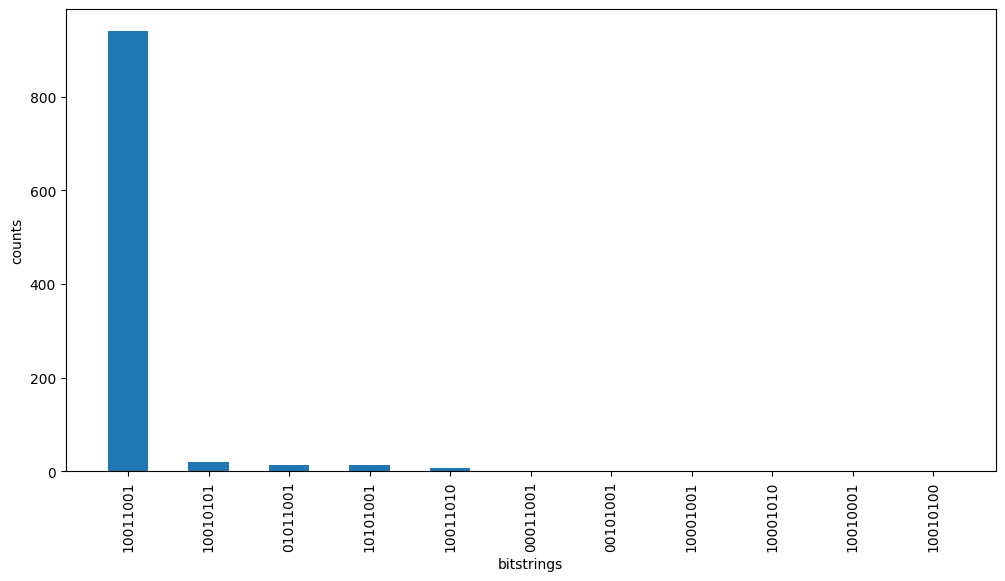

In [19]:
np.random.seed(0)
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()
plot_distribution(count_dict)

In [186]:
# pyqubo_graph = eval(str(qubo_graph).split('}')[-1][:-1])
# pyqubo_graph

In [187]:
# edges = pyqubo_graph[1]
# G2 = nx.Graph()
# for u, node_list in enumerate(edges):
#     for v in node_list:
#         G2.add_edge(u+1, v)

# nx.draw(G2, pos=nx.spring_layout(G2, seed=42), alpha=0.8, with_labels=True)

In [ ]:
res = gtn.solve(gtn.IndependentSet(qubo_graph, weights=qubo_weights), gtn.SingleConfigMax())
bitstring = list(map(int, list(str(res).split('}(')[-1].split(')')[0])))
bitstring

In [52]:
udm.map_config_back(qubo, bitstring)

array([0, 0, 0, 0, 1, 0], dtype=int64)

In [56]:
res = gtn.solve(gtn.SpinGlass(J,h), gtn.SingleConfigMax())
bitstring = list(map(int, list(str(res).split('}(')[-1].split(')')[0])))
bitstring

[0, 0, 0, 0, 1, 0]

In [81]:
def remove_order(g):
    addremove = [[] for _ in range(len(g.nodes))]
    adjm = nx.to_numpy_matrix(g).astype(int)
    counts = np.zeros(len(g.nodes), dtype=int).reshape(1, -1)
    totalcounts = np.sum(adjm, axis=0)
    removed = []
    for i, v in enumerate(g.nodes):
        counts += adjm[:, v].flatten()
        for j in range(len(g.nodes)):
            if (j not in removed) and (counts[0,j] == totalcounts[0, j]):
                index = max(i, list(g.nodes).index(j))
                addremove[index].append(j)
                removed.append(j)
    
    return addremove
    
def crossing_lattice(g):
    slots = [-1] * len(g.nodes)
    hslots = [-1] * len(g.nodes)
    rmorder = remove_order(g)
    print(g.nodes, rmorder)
    for i, (v, rs) in enumerate(zip(g.nodes, rmorder)):
        islot = slots.index(-1)
        slots[islot] = v
        hslots[i] = islot
        print(slots, hslots)
        for r in rs:
            slots[slots.index(r)] = 0
        print(slots)
    print(slots)

In [82]:
# map qubo
n = len(h)
assert J.shape == (n, n), "The size of coupling matrix J is not consistent with the size of onsite term h."

d = crossing_lattice(nx.complete_graph(n))
d = CrossingLattice(d.width, d.height, d.lines, SimpleGraph(n))
chunks = render_grid(T, d)  # You should define T appropriately

for i in range(n - 1):
    for j in range(i + 1, n):
        a = J[i, j]
        chunks[i, j][1:3, 1:3] += np.array([[-a, a], [a, -a]], dtype=T)

grid = glue(chunks, 0, 0)

gg, pins = post_process_grid(grid, h, -h)
mis_overhead = (n - 1) * n * 4 + n - 4

return QUBOResult(gg, pins, mis_overhead)

[0, 1, 2, 3, 4, 5] [[], [], [], [], [], [5, 0, 1, 2, 3, 4]]
[0, -1, -1, -1, -1, -1] [0, -1, -1, -1, -1, -1]
[0, -1, -1, -1, -1, -1]
[0, 1, -1, -1, -1, -1] [0, 1, -1, -1, -1, -1]
[0, 1, -1, -1, -1, -1]
[0, 1, 2, -1, -1, -1] [0, 1, 2, -1, -1, -1]
[0, 1, 2, -1, -1, -1]
[0, 1, 2, 3, -1, -1] [0, 1, 2, 3, -1, -1]
[0, 1, 2, 3, -1, -1]
[0, 1, 2, 3, 4, -1] [0, 1, 2, 3, 4, -1]
[0, 1, 2, 3, 4, -1]
[0, 1, 2, 3, 4, 5] [0, 1, 2, 3, 4, 5]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]


NameError: name 'CrossingLattice' is not defined

In [41]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])

for i in sort_zipped[:2]:
    node_idx = np.where(np.array(list(map(int, list(i[0])))) == 1)[0]
    print(np.array(G.nodes())[node_idx], i[1])

[1 3] [[-2]]
[0 2] [[-2]]


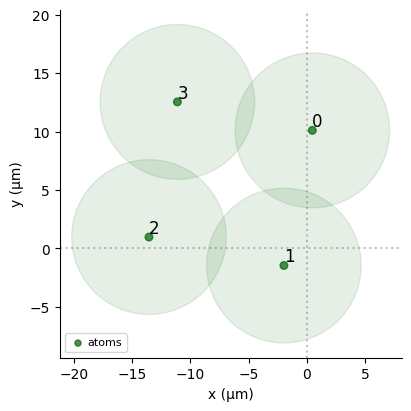

In [42]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(Chadoq2.interaction_coeff / pdist(new_coords) ** 6)
    return np.linalg.norm(new_Q - Q)

shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

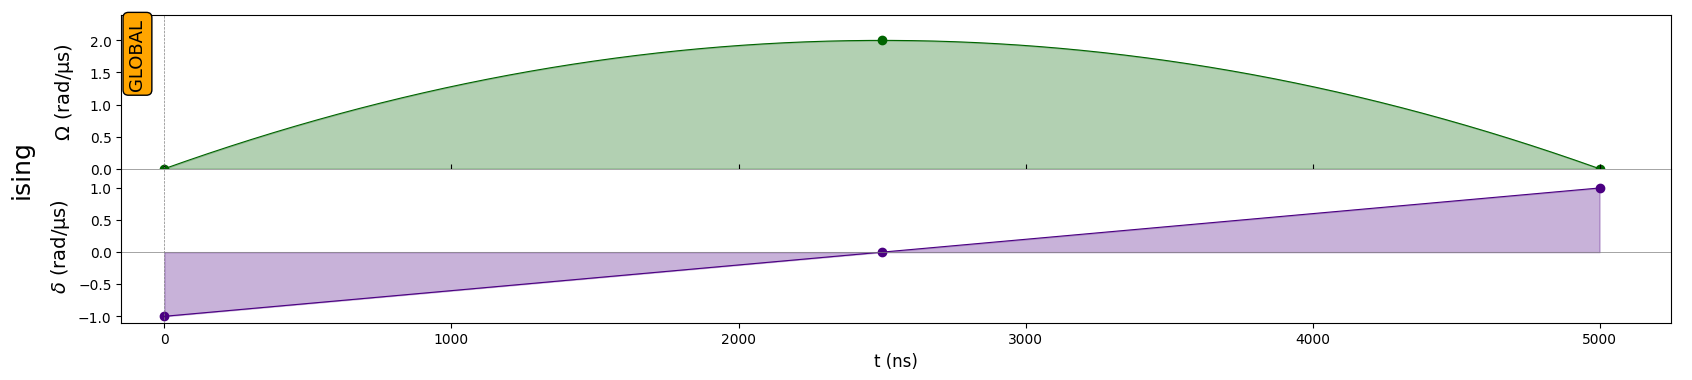

In [47]:
# We choose a median value between the min and the max
Omega = U
delta_0 = -1  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 5000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

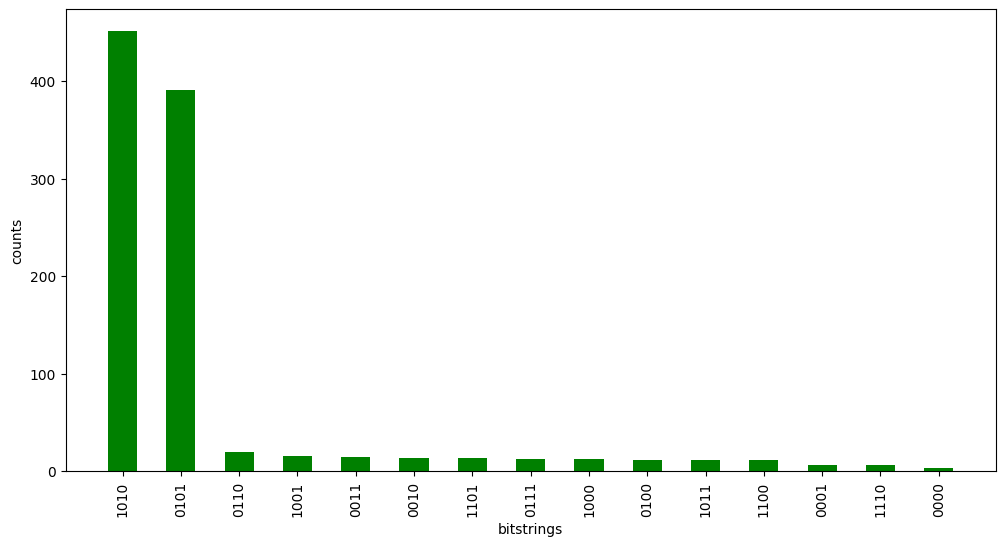

In [51]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()
    
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()
plot_distribution(count_dict)

## stuff

In [47]:
import numpy as np
from main import calc_location, set_wind_regime, calc_coefficients, qubo_fy
from pasqal_hybrid.pasqal_utils import get_qubo_matrix, embed_qubo, evaluate_mapping
from pulser.devices import Chadoq2

np.set_printoptions(linewidth=np.inf, suppress=True)

m = 7
n_wind = 36
axis_ = 3

n = pow(axis_, 2)
if axis_ == 10:
    step = 200  # cell size in meters
elif axis_ == 20:
    step = 100
else:
    step = 100

angle = 360 / n_wind
location_x, location_y = calc_location(axis_, step)
wind_speeds, prob_l = set_wind_regime(n_wind)
aggregated_coef, ss_coef, Epsilon, U, velocity = calc_coefficients(
    location_x, location_y, wind_speeds, prob_l, n, angle, n_wind
)

lam_ = 10500
bqm = qubo_fy(wind_speeds, prob_l, n, aggregated_coef, m, Epsilon, lam_)

In [48]:
h, (coupler_starts, coupler_ends, coupler_weights), _ = bqm.to_numpy_vectors(bqm.variables)
Q, scale_factor, detuning = get_qubo_matrix(h, coupler_starts, coupler_ends, coupler_weights)
np.round(Q, 4)

[[-137513.     31686.41   21079.11   31698.29   31622.6    21047.46   21085.72   21047.46   21039.96]
 [      0.   -137513.     31686.41   31708.06   31698.29   31622.6    21073.08   21085.72   21047.46]
 [      0.         0.   -137513.     21061.72   31708.06   31698.29   21074.16   21073.08   21085.72]
 [      0.         0.         0.   -137513.     31686.41   21079.11   31698.29   31622.6    21047.46]
 [      0.         0.         0.         0.   -137513.     31686.41   31708.06   31698.29   31622.6 ]
 [      0.         0.         0.         0.         0.   -137513.     21061.72   31708.06   31698.29]
 [      0.         0.         0.         0.         0.         0.   -137513.     31686.41   21079.11]
 [      0.         0.         0.         0.         0.         0.         0.   -137513.     31686.41]
 [      0.         0.         0.         0.         0.         0.         0.         0.   -137513.  ]]


array([[-15.7   ,   3.6177,   2.4066,   3.619 ,   3.6104,   2.403 ,   2.4074,   2.403 ,   2.4022],
       [  0.    , -15.7   ,   3.6177,   3.6201,   3.619 ,   3.6104,   2.4059,   2.4074,   2.403 ],
       [  0.    ,   0.    , -15.7   ,   2.4046,   3.6201,   3.619 ,   2.4061,   2.4059,   2.4074],
       [  0.    ,   0.    ,   0.    , -15.7   ,   3.6177,   2.4066,   3.619 ,   3.6104,   2.403 ],
       [  0.    ,   0.    ,   0.    ,   0.    , -15.7   ,   3.6177,   3.6201,   3.619 ,   3.6104],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    , -15.7   ,   2.4046,   3.6201,   3.619 ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    , -15.7   ,   3.6177,   2.4066],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    , -15.7   ,   3.6177],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    , -15.7   ]])

<br><br>

0 ------ 1 ------ 2<br>
|$\;\;\;\;\;\;\;\;$|$\;\;\;\;\;\;\;\;$| <br>
3 ------ 4 ------ 5<br>
|$\;\;\;\;\;\;\;\;$|$\;\;\;\;\;\;\;\;$| <br>
6 ------ 7 ------ 8<br>

In [49]:
from scipy.spatial.distance import pdist, squareform

coords = embed_qubo(Q, seed=42)
mat = np.triu(squareform(Chadoq2.interaction_coeff / pdist(coords)**6))
np.round(mat, 4)

array([[0.    , 0.0019, 0.0276, 0.0232, 1.356 , 1.3721, 0.0239, 0.1883, 0.2995],
       [0.    , 0.    , 0.0012, 1.1808, 0.0011, 0.0204, 0.0534, 0.0116, 0.0022],
       [0.    , 0.    , 0.    , 0.0068, 1.2459, 0.0143, 0.0012, 0.7245, 0.0015],
       [0.    , 0.    , 0.    , 0.    , 0.0094, 1.2666, 0.5093, 0.2558, 0.0163],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0797, 0.0034, 0.6667, 0.0096],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.7026, 0.6476, 0.3487],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0145, 0.2578],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0091],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]])

In [50]:
Omega = np.median(Q[Q > 0].flatten())
Omega

3.6103849709708795

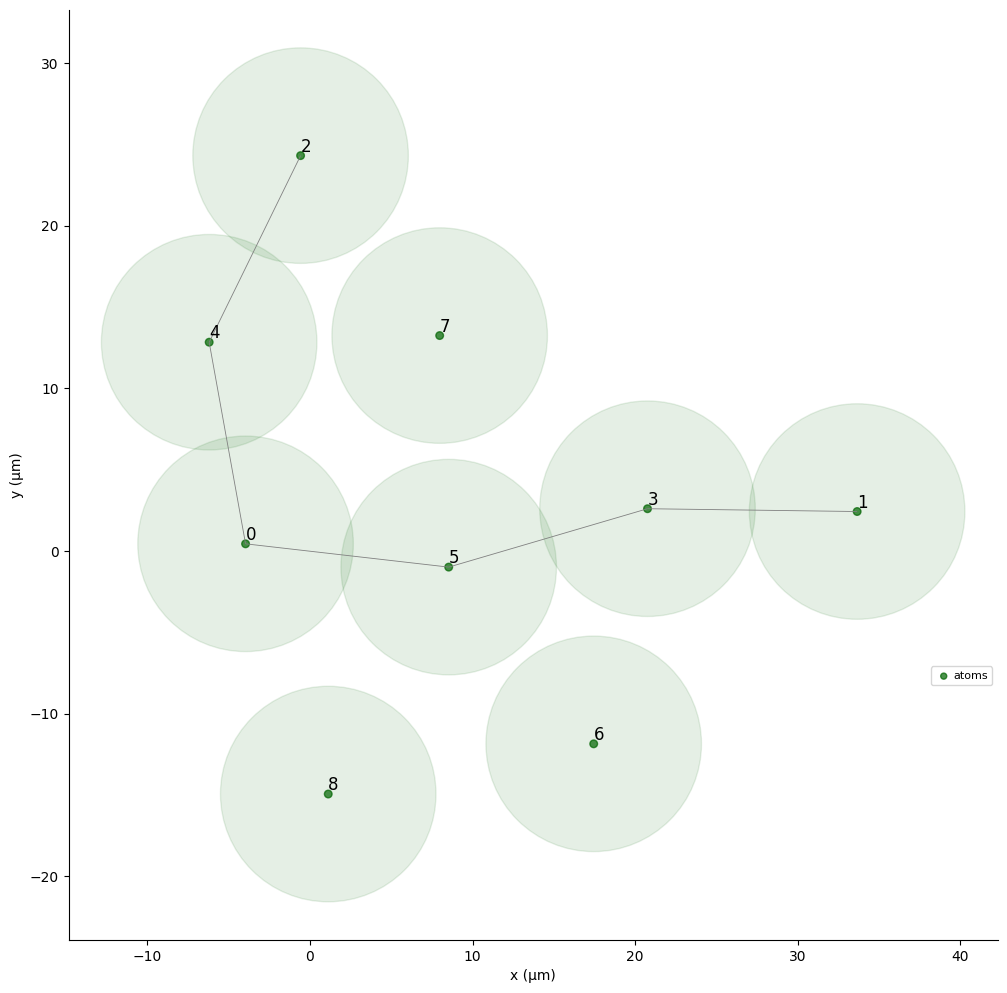

In [51]:
from pulser import Pulse, Register, Sequence
from pulser.devices import Chadoq2

qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

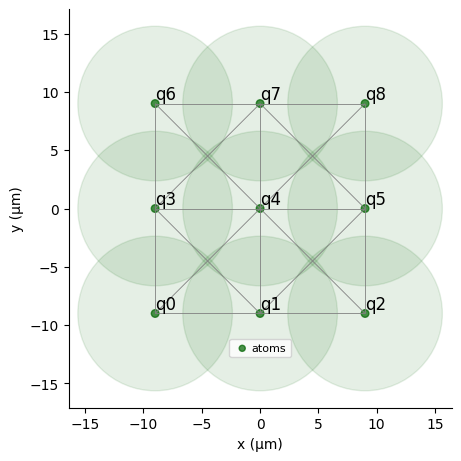

In [95]:
from pulser.register.special_layouts import SquareLatticeLayout

square_layout = SquareLatticeLayout(3, 3, spacing=9)

square_layout.square_register(side=3).draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

## plotting

In [20]:
import json

In [21]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from main import calc_location
import time

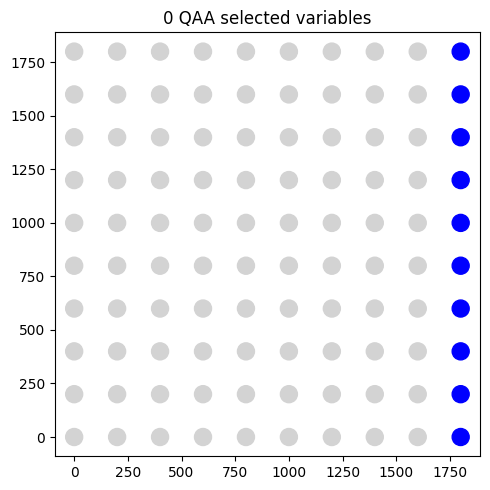

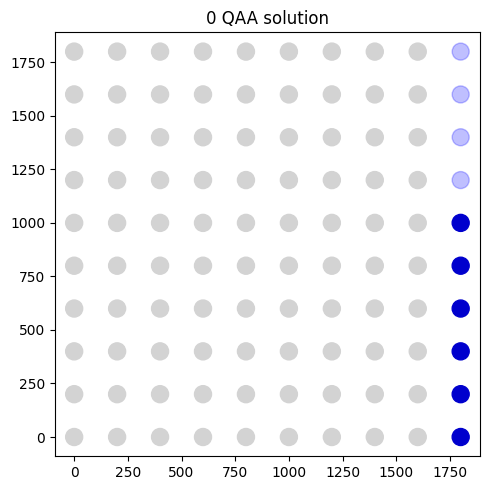

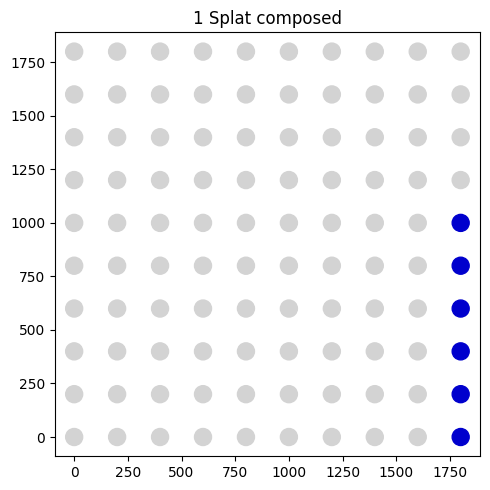

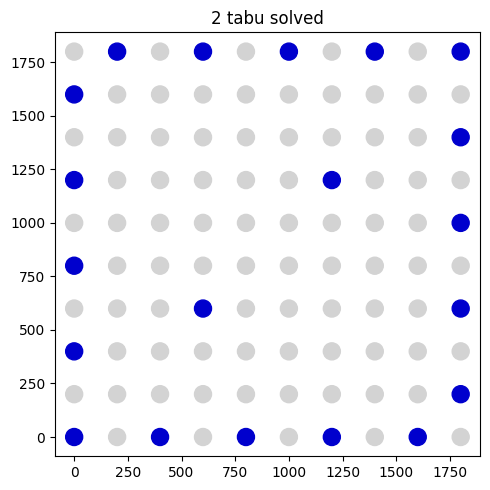

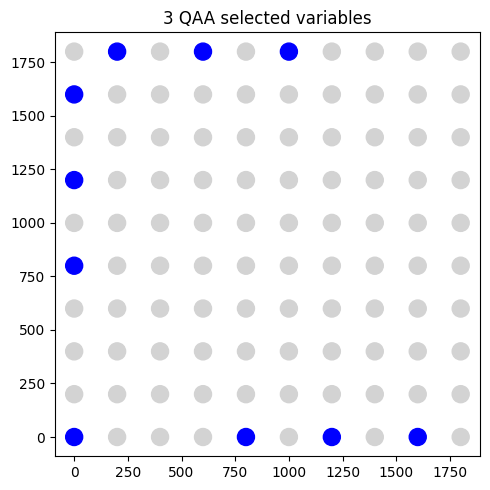

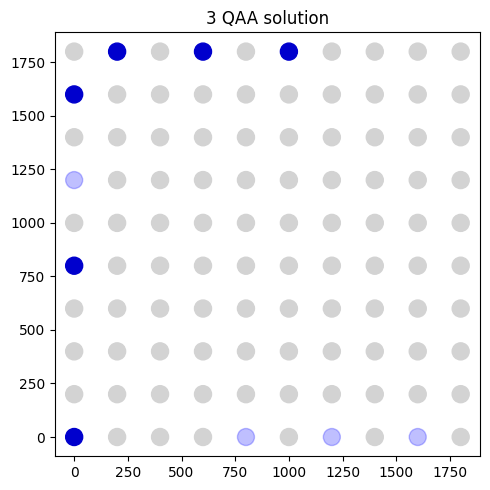

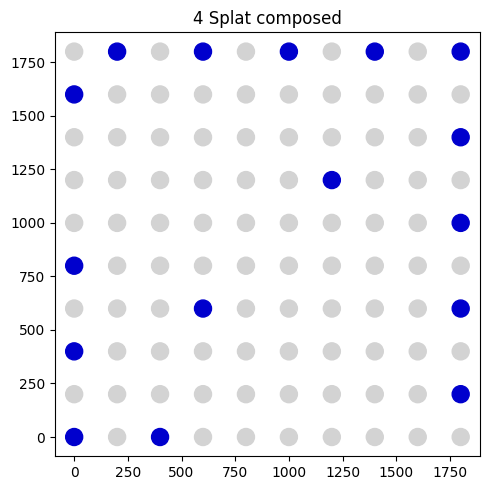

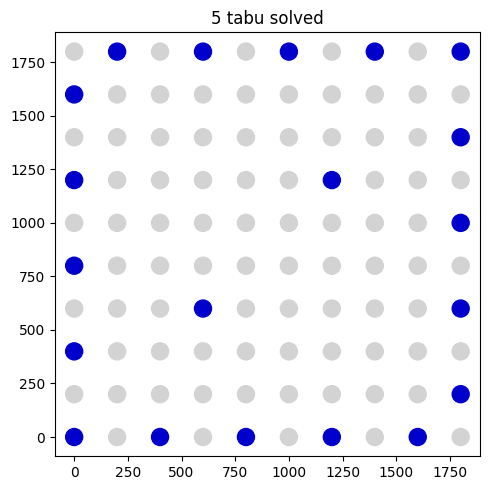

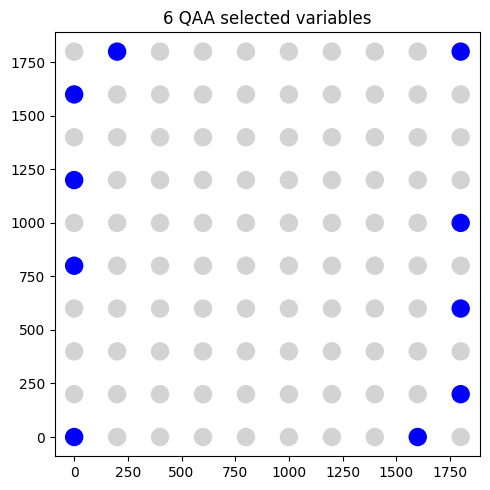

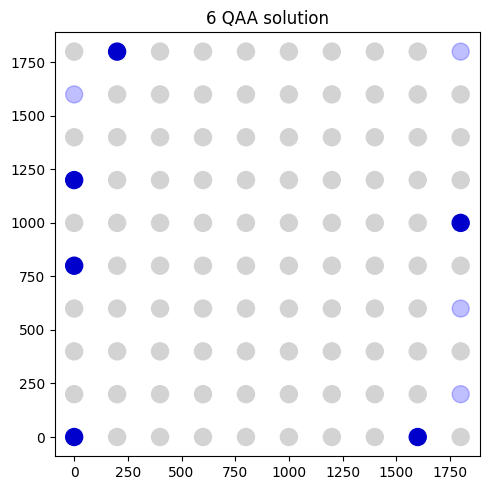

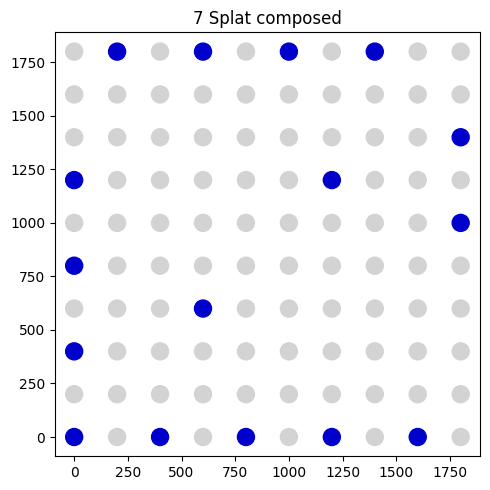

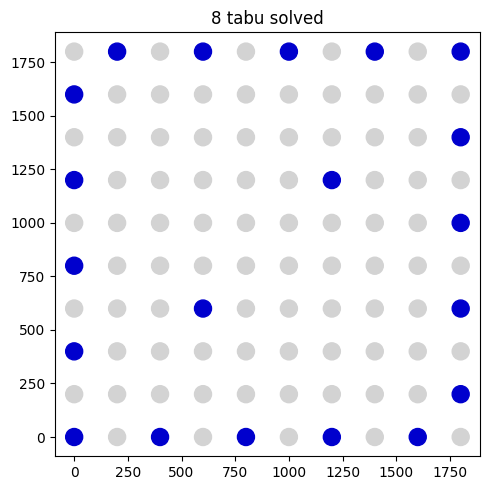

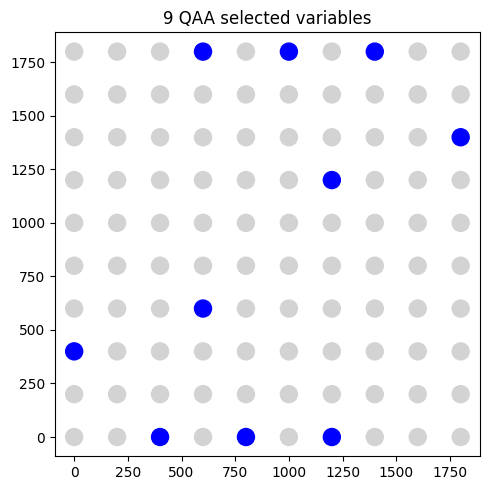

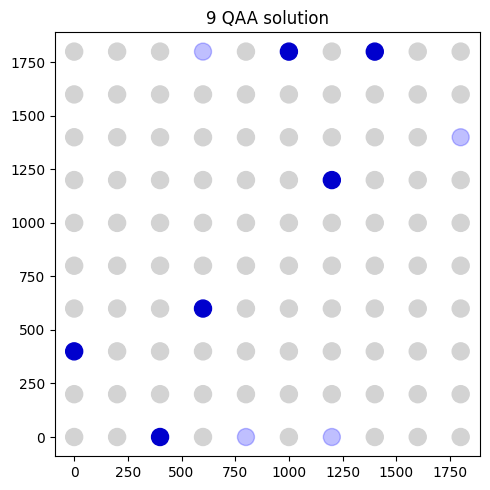

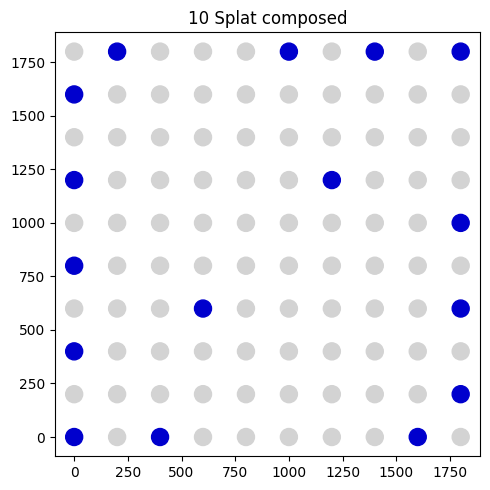

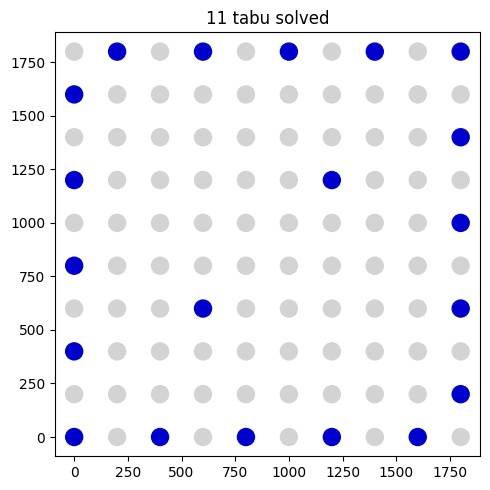

In [81]:
file = open("log.txt", "r")
data = [json.loads(line) for line in file.readlines()]

axis_ = 10
step = 200
location_x, location_y = calc_location(axis_, step)


for i, d in enumerate(data):
    sampler_type = d['data']['sampler_type']
    
    if sampler_type == 'sampler':
        subsamples = d['data']['subsamples']
        sample_data = subsamples['sample_data']['data']
        energies = subsamples['vectors']['energy']['data']
        counts = subsamples['vectors']['num_occurrences']['data']
        variables = np.array(list(map(lambda x: int(x.split('x')[-1]), subsamples['variable_labels'])))
        
        idx = np.argmax(counts)
        sample = np.array(sample_data[idx])
        energy = energies[idx]

        colors = np.array(['#D3D3D3'] * len(location_x), dtype=np.dtype('U25'))
        colors[variables] = 'blue'

        plt.figure(figsize=(5,5))
        plt.title(f'{i} QAA selected variables')
        plt.scatter(location_x, location_y, c= colors, s=150)
        # plt.show()
        
        alpha = np.array([1.0] * len(location_x))
        alpha[variables] = 0.25

        selected_nodes = variables[np.where(sample == 1)[0]]
        alpha[selected_nodes] = 1.0
        colors[selected_nodes] = 'mediumblue'

        plt.figure(figsize=(5,5))
        plt.title(f'{i} QAA solution')
        plt.scatter(location_x, location_y, c= colors, s=150, alpha=alpha)
        # plt.show()

    elif sampler_type == 'composer':
        samples = d['data']['samples']
        sample_data = samples['sample_data']['data']
        energies = samples['vectors']['energy']['data']
        counts = samples['vectors']['num_occurrences']['data']
        variables = np.array(list(map(lambda x: int(x.split('x')[-1]), samples['variable_labels'])))
        
        idx = np.argmax(counts)
        sample = np.array(sample_data[idx])
        energy = energies[idx]

        colors = np.array(['#D3D3D3'] * len(location_x), dtype=np.dtype('U25'))
        selected_nodes = variables[np.where(sample == 1)[0]]
        colors[selected_nodes] = 'mediumblue'

        plt.figure(figsize=(5,5))
        plt.title(f'{i} Splat composed')
        plt.scatter(location_x, location_y, c= colors, s=150)

    elif sampler_type == 'tabu':
        samples = d['data']['samples']
        sample_data = samples['sample_data']['data']
        energies = samples['vectors']['energy']['data']
        counts = samples['vectors']['num_occurrences']['data']
        variables = np.array(list(map(lambda x: int(x.split('x')[-1]), samples['variable_labels'])))
        
        idx = np.argmax(counts)
        sample = np.array(sample_data[idx])
        energy = energies[idx]

        colors = np.array(['#D3D3D3'] * len(location_x), dtype=np.dtype('U25'))
        selected_nodes = variables[np.where(sample == 1)[0]]
        colors[selected_nodes] = 'mediumblue'

        plt.figure(figsize=(5,5))
        plt.title(f'{i} tabu solved')
        plt.scatter(location_x, location_y, c= colors, s=150)
    
    time.sleep(0.2)